TLDR:  
embed abstracts,  
kmeans clustered by abstracts by semantic meaning,  
we grab tags from each cluster and assign them to each URL,  
we then run k-means again for x amount of runs,  
at the end for each url we add up the amount of times it was assigned each tag and take the top 5 tags. 

next steps for improving tags:  
sort out the meaningless tags manually D:  
adjust num runs and k cluster numbers  
maybe only use the top 75ish most popular tags?  
Right now there are 151 unique tags  

In [199]:
import pandas as pd
from keybert import KeyBERT
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
df = pd.read_csv('cleaned_url_data.csv')

df.head()

,URL,HTML,Title,Abstract,Publish_date,Authors,KMeansTags
0,https://deepmind.google/research/publications/...,Automated Discovery of Interpretable Cognitive...,Automated Discovery of Interpretable Cognitive...,A principal goal of computational neuroscience...,6 February 2025,"Pablo Castro Rivadeneira, Kim Stachenfeld, Kev...","['programs', 'rl', 'discover', 'reward', 'mode..."
1,https://deepmind.google/research/publications/...,Scaling Pre-training to One Hundred Billion Da...,Scaling Pre-training to One Hundred Billion Da...,We provide an empirical investigation of the p...,11 February 2025,"Xiao Wang, Ibrahim Alabdulmohsin, Daniel Salz,...","['scale', 'vision', 'video', 'image', 'data']"
2,https://deepmind.google/research/publications/...,Delta Variances - Google DeepMind ...,Generate videos in Gemini and Whisk with Veo 2...,Decision makers may suffer from uncertainty in...,20 February 2025,"Simon Schmitt, John Shawe-Taylor, Hado van Has...","['neural', 'delta', 'weather', 'states', 'netw..."
3,https://deepmind.google/research/publications/...,Effective Kernel Fuzzing with Learned White-bo...,Veo 2 15 April 2025 Effectiv...,Kernel fuzzers rely heavily on program mutatio...,1 April 2025,"Sishuai Gong, Wang Rui, Deniz Altinbüken, Pedr...","['kernel', 'snowplow', 'coverage', 'programs',..."
4,https://deepmind.google/research/publications/...,TIPS: Text-Image Pretraining with Spatial awar...,Whisk with Veo 2 15 April 2025 ...,While image-text representation learning has b...,10 March 2025,"Kevis-Kokitsi Maninis, Kaifeng Chen, Soham Gho...","['image', 'tasks', 'dense', 'video', 'vision']"


This creates semantic embeddings of the abstracts, this will allow us to cluster each paper semantically when using k-means

In [200]:

#  pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

abstract_embeddings = model.encode(df['Abstract'])
print(abstract_embeddings.shape)

(199, 384)


Manual implementation of kemans using hw 3 as a start

In [201]:
def kmeans(data, k=40, tol=0.005):
    n_samples = data.shape[0]
    converged = False

    # random centroids
    indices = np.random.choice(n_samples, size=k, replace=False)
    centroids = data[indices]

    while not converged:
        # take euclidian distance
        dists = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)  
        # assign for each centroid
        labels = np.argmin(dists, axis=1)

        old_centroids = centroids.copy()
        #update centroids
        for i in range(k):
            if np.any(labels == i):
                centroids[i] = data[labels == i].mean(axis=0)

        # Check convergence
        centroid_distances = np.linalg.norm(centroids - old_centroids, axis=1)
        if np.all(centroid_distances < tol):
            converged = True


    # compute  inertia
    final_dists = np.linalg.norm(data - centroids[labels], axis=1)
    inertia = np.sum(final_dists ** 2)
    
    return centroids, labels, inertia


Trying to find a optimal k to use, using inertia which is the the sum of the squared distances between each point and its cluster's center. 

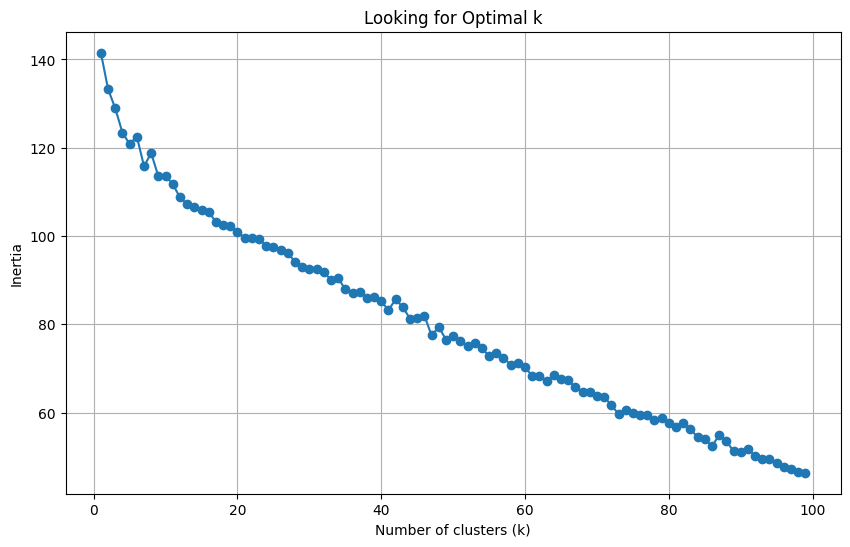

In [202]:
inertias = []
k_values = range(1, 100)  
for k in k_values:
    centroids, labels, inertia = kmeans(abstract_embeddings, k=k)
    inertias.append(inertia)  

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Looking for Optimal k')
plt.grid(True)
plt.show()

hmm I want to pick a higher than normal k to get more tags, but there isn't a obvious elbow except maybe at like k = 15ish,   
But i want to use a higher k than 15 since I want some more specific tags.  
I will try with k = 50 first, meaning theres around 5 papers per cluster  

Running k means multiple times to get different initial clusters. 

In [203]:
import random
num_kmeans_runs = 40
# k = 30

labels_all_runs = np.zeros((num_kmeans_runs, len(abstract_embeddings)))  

for i in range(num_kmeans_runs):
    # We now pickj a random k between 30-40
    k = random.randint(25, 40)

    centroids, labels, inertia = kmeans(abstract_embeddings, k=k)
    labels_all_runs[i] = labels  

Was debating over Tfid or bag of words, bag of words is simple to implement from scratch, but other than that is just a worse algorithm for tagging. Tfid assigns weight to words given all the abstracts allowing it to pick out more signifigant words. It also  uses stopword to prevent only catching the most popular words such as: "is, and, to, then,". Learn more about it here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [204]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=750,
                             token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b' )#token pattern is regex for each feature to be as least 2 letters and no numbers

tfidf_matrix = vectorizer.fit_transform(df['Abstract'])
potential_tags = np.array(vectorizer.get_feature_names_out())
potential_tags[:20]

array(['ability', 'able', 'abstract', 'according', 'accuracy', 'accurate',
       'accurately', 'achieve', 'achieves', 'action', 'actions',
       'activations', 'adapt', 'adaptation', 'adapting', 'additional',
       'additionally', 'address', 'agent', 'agents'], dtype=object)

In [205]:

tag_counts_per_url = defaultdict(Counter)

# run for each set of clusters created by k-means 
for labels in labels_all_runs:
    cluster_tags = {}

    # Extract tags
    for cluster_num in np.unique(labels):
        cluster_indexes = np.where(labels == cluster_num)[0]
        if len(cluster_indexes) > 0:
            cluster_tfidf = tfidf_matrix[cluster_indexes].mean(axis=0).A1
        else:
            cluster_tfidf = np.zeros(tfidf_matrix.shape[1])  
        top_indices = np.argsort(cluster_tfidf)
        top_indices = top_indices[::-1][:5]
        cluster_tags[cluster_num] = potential_tags[top_indices]

    # Assign tags to each URL
    for i in range(len(labels)):
        for tag in cluster_tags[int(labels[i])]:
            tag_counts_per_url[i][tag] += 1


Finally we grab the top 5 tags for each URL

In [206]:
final_tags = {}
for i, counter in tag_counts_per_url.items():
    final_tags[i] = [tag for tag, _ in counter.most_common(5)]  


In [207]:
all_final_tags = set(tag for tags in final_tags.values() for tag in tags)
print('total unique  kmeans tags: ', len(all_final_tags))


total unique  kmeans tags:  169


Now we should probably check the tags against the actual abstracts manually

In [208]:
for i in range(0,25):
    print('Title: ', df["Title"][i])
    print('URL: ', df["URL"][i])
    print('Tags: ', final_tags[i])
    

Title:  Automated Discovery of Interpretable Cognitive Programs underlying Reward-guided behavior
URL:  https://deepmind.google/research/publications/130468
Tags:  ['programs', 'search', 'reward', 'rl', 'learning']
Title:  Scaling Pre-training to One Hundred Billion Data for Vision Language Models
URL:  https://deepmind.google/research/publications/132991
Tags:  ['scale', 'vision', 'video', 'data', 'models']
Title:  Generate videos in Gemini and Whisk with Veo 2 15 April 2025                   Delta Variances
URL:  https://deepmind.google/research/publications/112791
Tags:  ['neural', 'uncertainty', 'weather', 'delta', 'states']
Title:  Veo 2 15 April 2025                   Effective Kernel Fuzzing with Learned White-box Test Mutators
URL:  https://deepmind.google/research/publications/127036
Tags:  ['kernel', 'program', 'optimization', 'programs', 'search']
Title:  Whisk with Veo 2 15 April 2025                   TIPS: Text-Image Pretraining with Spatial awareness
URL:  https://deepmi

Now did using k-means actually make a difference? Lets check!  
Baseline is what TFID would have done by itself on each abstract no k-means

In [209]:
baseline_tags = {} #No k-means
for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = np.argsort(row)[::-1][:5] 
    baseline_tags[i] = list(potential_tags[top_indices])

all_baseline_tags = set(tag for tags in baseline_tags.values() for tag in tags)
print('total unique  baseline tags: ', len(all_baseline_tags))

total unique  baseline tags:  468


We can see that since our total unque tags for kmeans is much lower, this means that k-means was able to generalize the tags/topics better accross the papers.

There is bit a of similarity but the kmeans definitely signifigantly changes the tags generated from each abstract.

In [210]:
overlaps = []
for i in range(len(df)):
    set_kmeans = set(final_tags.get(i, [])) 
    set_baseline = set(baseline_tags.get(i, [])) 

    intersection = set_kmeans & set_baseline
    union = set_kmeans | set_baseline

    if union:  
        jaccard = len(intersection) / len(union)
        overlaps.append(jaccard)

print(f"Jaccards similarity  {np.mean(overlaps):.4f}")

Jaccards similarity  0.2485


Taking a closer look at the different tags:

In [211]:
for i in range(3): 
    print('Title: ', df["Title"][i])
    print("KMeans Tags:", final_tags[i])
    print("Baseline Tags:", baseline_tags[i])
    print("-" * 40)


Title:  Automated Discovery of Interpretable Cognitive Programs underlying Reward-guided behavior
KMeans Tags: ['programs', 'search', 'reward', 'rl', 'learning']
Baseline Tags: ['programs', 'discover', 'program', 'cognitive', 'predicting']
----------------------------------------
Title:  Scaling Pre-training to One Hundred Billion Data for Vision Language Models
KMeans Tags: ['scale', 'vision', 'video', 'data', 'models']
Baseline Tags: ['scale', 'diversity', 'gains', 'examples', 'benchmarks']
----------------------------------------
Title:  Generate videos in Gemini and Whisk with Veo 2 15 April 2025                   Delta Variances
KMeans Tags: ['neural', 'uncertainty', 'weather', 'delta', 'states']
Baseline Tags: ['delta', 'neural', 'uncertainty', 'networks', 'epistemic']
----------------------------------------


To imrpove tagging: I'm currently seeing some tag words that are a bit meaningless. In what we printed above we see that feature and features were keywords from the first abstract, these tags don't really make sense to me right now. To improve this we can add custom stopwords that prevent our TFID model from considering those words. We would have to manually add those stop words though.  

Other steps we can do to improve tagging is messing around with k for k means, maybe we can select random ks between a range(this might be annmoying to implemnt )? k =40 was kind of arbitually selected. Also we can look into howv many iterations of k means to do. 

Another thing we can do to clean the tags is to count up the numbers of each tag and say we only want the top 75 or so and then remove tags from urls that arent in the top 75

In [212]:

df['KMeansTags'] = df.index.map(lambda i: final_tags.get(i, []))

df.head()

,URL,HTML,Title,Abstract,Publish_date,Authors,KMeansTags
0,https://deepmind.google/research/publications/...,Automated Discovery of Interpretable Cognitive...,Automated Discovery of Interpretable Cognitive...,A principal goal of computational neuroscience...,6 February 2025,"Pablo Castro Rivadeneira, Kim Stachenfeld, Kev...","[programs, search, reward, rl, learning]"
1,https://deepmind.google/research/publications/...,Scaling Pre-training to One Hundred Billion Da...,Scaling Pre-training to One Hundred Billion Da...,We provide an empirical investigation of the p...,11 February 2025,"Xiao Wang, Ibrahim Alabdulmohsin, Daniel Salz,...","[scale, vision, video, data, models]"
2,https://deepmind.google/research/publications/...,Delta Variances - Google DeepMind ...,Generate videos in Gemini and Whisk with Veo 2...,Decision makers may suffer from uncertainty in...,20 February 2025,"Simon Schmitt, John Shawe-Taylor, Hado van Has...","[neural, uncertainty, weather, delta, states]"
3,https://deepmind.google/research/publications/...,Effective Kernel Fuzzing with Learned White-bo...,Veo 2 15 April 2025 Effectiv...,Kernel fuzzers rely heavily on program mutatio...,1 April 2025,"Sishuai Gong, Wang Rui, Deniz Altinbüken, Pedr...","[kernel, program, optimization, programs, search]"
4,https://deepmind.google/research/publications/...,TIPS: Text-Image Pretraining with Spatial awar...,Whisk with Veo 2 15 April 2025 ...,While image-text representation learning has b...,10 March 2025,"Kevis-Kokitsi Maninis, Kaifeng Chen, Soham Gho...","[tasks, image, scene, video, visual]"


In [213]:
df.to_csv('cleaned_url_data.csv', index=False)


Below is another model for extracting keywords from text. I just wantedf to sompare it to our k means method

In [ ]:

kw_model = KeyBERT('all-MiniLM-L6-v2')

keywords = kw_model.extract_keywords(df["Abstract"], top_n=5)


In [145]:
for i in range(15):
    print('Tags: ', final_tags[i])
    print('ketbert: ', keywords[i])
    

Tags:  ['programs', 'reward', 'rl', 'tasks', 'models']
ketbert:  [('behavioral', 0.408), ('reward', 0.3432), ('neural', 0.3415), ('program', 0.3414), ('predictive', 0.3361)]
Tags:  ['scale', 'vision', 'image', 'tasks', 'embedding']
ketbert:  [('multilinguality', 0.4022), ('multimodal', 0.3813), ('captions', 0.3723), ('diversity', 0.3378), ('cultural', 0.3288)]
Tags:  ['neural', 'uncertainty', 'delta', 'weather', 'networks']
ketbert:  [('uncertainty', 0.4599), ('variances', 0.3109), ('networks', 0.2981), ('empirically', 0.2965), ('variance', 0.2913)]
Tags:  ['kernel', 'snowplow', 'coverage', 'program', 'ml']
ketbert:  [('fuzzing', 0.4505), ('mutation', 0.4053), ('mutations', 0.3719), ('coverage', 0.35), ('kernels', 0.3409)]
Tags:  ['image', 'tasks', 'vision', 'video', 'scale']
ketbert:  [('captions', 0.3986), ('deepmind', 0.377), ('text', 0.3234), ('supervised', 0.3084), ('learning', 0.2996)]
Tags:  ['entropy', 'algorithmic', 'time', 'nash', 'game']
ketbert:  [('entropy', 0.5618), ('the